dane: https://www.bco-dmo.org/dataset/810032

In [2]:
import pandas as pd
df = pd.read_csv("surface_n2o_compilation.csv")
df

,cruise,date,year,month,day,latitude,longitude,depth,n2o_ppb,n2o_nM,dn2o_ppb,atmPressure,temperature,salinity
0,JOINT II Leg 0,1976-03-08,1976,3,8,22.0200,250.9200,0.0,524.622831,11.5900,224.739949,1.001743,21.900,34.664284
1,JOINT II Leg 0,1976-03-10,1976,3,10,15.6150,256.8200,0.0,365.587598,6.8200,65.701757,0.999566,27.700,33.795834
2,JOINT II Leg 0,1976-03-12,1976,3,12,9.5400,262.5600,0.0,435.085126,8.4100,135.196326,0.998316,26.400,33.940033
3,JOINT II Leg 0,1976-03-13,1976,3,13,5.1500,266.6200,0.0,462.589867,8.2900,162.699587,0.997575,29.200,32.883614
4,JOINT II Leg 0,1976-03-16,1976,3,16,-3.2200,274.7600,0.0,431.508109,8.0700,131.613389,0.997930,27.400,34.689255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158193,M100-1,2013-09-29,2013,9,29,-21.0882,12.4816,0.0,398.871600,10.5164,73.004470,1.002503,15.536,33.940000
158194,M100-1,2013-09-29,2013,9,29,-21.0902,12.4828,0.0,399.690200,10.5318,73.823095,1.002501,15.535,33.902000
158195,M100-1,2013-09-29,2013,9,29,-21.0937,12.4851,0.0,400.187600,10.5330,74.320540,1.002501,15.539,34.016000
158196,M100-1,2013-09-29,2013,9,29,-21.0955,12.4862,0.0,400.550400,10.5594,74.683363,1.002500,15.539,33.940000


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df = pd.read_csv("surface_n2o_compilation.csv")

features = ["latitude", "longitude", "depth", "atmPressure", "temperature", "salinity", "month"]
X = df[features]
y = df["dn2o_ppb"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True, n_jobs=-1)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
print("Test set:")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))


y_oob_pred = model.oob_prediction_

print("\nOut-of-Bag (OOB) predictions on training set:")
print("RMSE:", np.sqrt(mean_squared_error(y_train, y_oob_pred)))
print("R²:", r2_score(y_train, y_oob_pred))


Test set:
RMSE: 184.55893943213422
R²: 0.6654970176382515

Out-of-Bag (OOB) predictions on training set:
RMSE: 141.2840465004441
R²: 0.7771228908998548


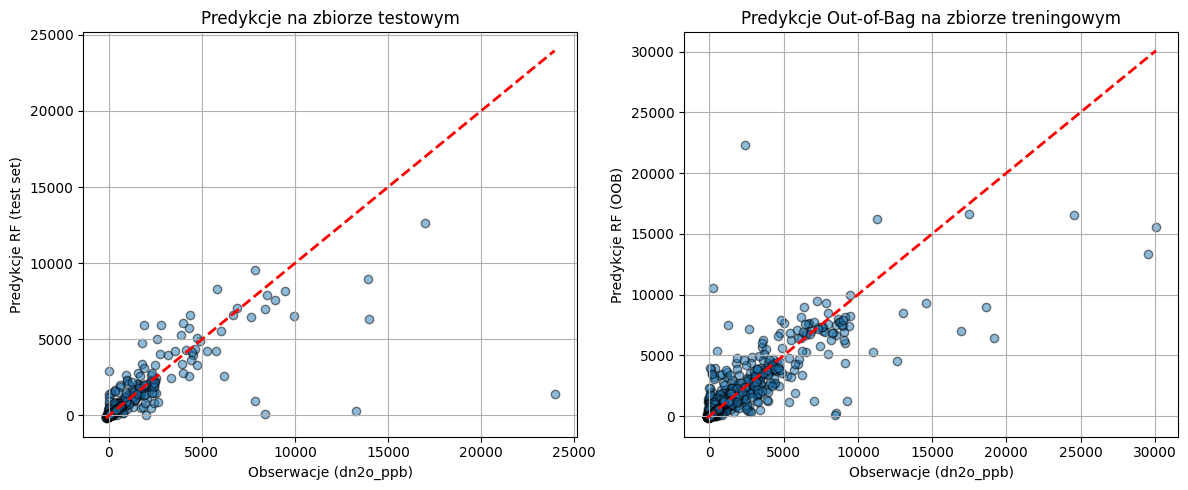

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Obserwacje (dn2o_ppb)")
plt.ylabel("Predykcje RF (test set)")
plt.title("Predykcje na zbiorze testowym")
plt.grid(True)


plt.subplot(1, 2, 2)
plt.scatter(y_train, y_oob_pred, alpha=0.5, edgecolor='k')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel("Obserwacje (dn2o_ppb)")
plt.ylabel("Predykcje RF (OOB)")
plt.title("Predykcje Out-of-Bag na zbiorze treningowym")
plt.grid(True)

plt.tight_layout()
plt.show()


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Test set:
RMSE (ppb): 14.410
R² (ppb): 0.978
RMSE (natm): 1.441e+01

Out-of-Bag (OOB) predictions on training set:
RMSE (ppb): 13.850
R² (ppb): 0.980


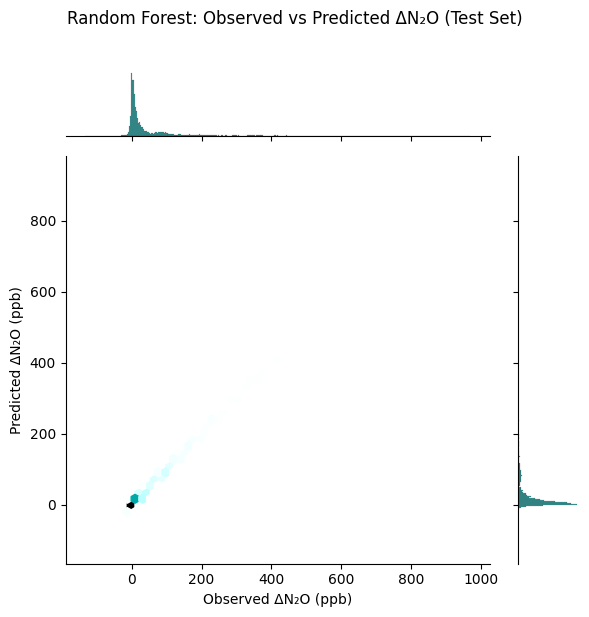

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_csv("surface_n2o_compilation.csv")
features = ["latitude", "longitude", "depth", "atmPressure", "temperature", "salinity", "month"]
target = "dn2o_ppb"


df = df.dropna(subset=features + [target])

# remove outliers using z-score
df = df[(np.abs(zscore(df[features + [target]])) < 3).all(axis=1)]

# feature engineering
df["temp_sal"] = df["temperature"] * df["salinity"]
df["depth_pressure"] = df["depth"] * df["atmPressure"]
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)


features += ["temp_sal", "depth_pressure", "month_sin", "month_cos"]


X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
    "n_estimators": [200],
    "max_depth": [None, 20],
    "min_samples_split": [2, 5],
    "max_features": ["sqrt"]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42, oob_score=True, n_jobs=-1),
                    param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)
model = grid.best_estimator_


y_pred = model.predict(X_test)
rmse_ppb = np.sqrt(mean_squared_error(y_test, y_pred))
r2_ppb = r2_score(y_test, y_pred)

# Convert to natm using atmospheric pressure
#atm_pressure_test = X_test["atmPressure"].values
#y_test_natm = y_test * 1e-9 * atm_pressure_test
#y_pred_natm = y_pred * 1e-9 * atm_pressure_test
rmse_natm = np.sqrt(mean_squared_error(y_test, y_pred))

# OOB score
y_oob_pred = model.oob_prediction_
rmse_oob = np.sqrt(mean_squared_error(y_train, y_oob_pred))
r2_oob = r2_score(y_train, y_oob_pred)


print("Test set:")
print(f"RMSE (ppb): {rmse_ppb:.3f}")
print(f"R² (ppb): {r2_ppb:.3f}")
print(f"RMSE (natm): {rmse_natm:.3e}")

print("\nOut-of-Bag (OOB) predictions on training set:")
print(f"RMSE (ppb): {rmse_oob:.3f}")
print(f"R² (ppb): {r2_oob:.3f}")

sns.jointplot(x=y_test, y=y_pred, kind="hex", color="teal")
plt.xlabel("Observed ΔN₂O (ppb)")
plt.ylabel("Predicted ΔN₂O (ppb)")
plt.suptitle("Random Forest: Observed vs Predicted ΔN₂O (Test Set)", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn import TabPFNRegressor
import numpy as np

df = pd.read_csv("surface_n2o_compilation.csv")

features = ["latitude", "longitude", "depth", "atmPressure", "temperature", "salinity", "month"]
X = df[features]
y = df["dn2o_ppb"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_samples = 100
if len(X_train) > max_samples:
    sample_idx = np.random.choice(len(X_train), max_samples, replace=False)
    X_train_sub = X_train.iloc[sample_idx]
    y_train_sub = y_train.iloc[sample_idx]
else:
    X_train_sub = X_train
    y_train_sub = y_train


regressor = TabPFNRegressor()
regressor.fit(X_train_sub, y_train_sub)


predictions = regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)


/usr/local/lib/python3.11/dist-packages/tabpfn/base.py:101: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-regressor.ckpt.
  model, bardist, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-regressor.ckpt:   0%|          | 0.00/44.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

In [1]:
!pip install tabpfn-client


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.9 MB/s eta 0:00:00


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tabpfn_client import TabPFNRegressor  # note different import
import numpy as np

# Load data
df = pd.read_csv("surface_n2o_compilation.csv")

features = ["latitude", "longitude", "depth", "atmPressure", "temperature", "salinity", "month"]
X = df[features]
y = df["dn2o_ppb"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optionally subsample if needed, but client can handle bigger sets faster
max_samples = 9999
if len(X_train) > max_samples:
    sample_idx = np.random.choice(len(X_train), max_samples, replace=False)
    X_train_sub = X_train.iloc[sample_idx]
    y_train_sub = y_train.iloc[sample_idx]
else:
    X_train_sub = X_train
    y_train_sub = y_train

# Create the client regressor
regressor = TabPFNRegressor()

# Train the model remotely
regressor.fit(X_train_sub.values, y_train_sub.values)

# Predict on test data
predictions = regressor.predict(X_test.values[:10000])

mse = mean_squared_error(y_test[:10000], predictions[:10000])
r2 = r2_score(y_test, predictions)

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)


Processing: 100%|██████████| [00:21<00:00]


ValueError: Found input variables with inconsistent numbers of samples: [10000, 1000]

In [8]:
mse = mean_squared_error(y_test[:10000], predictions[:10000])
r2 = r2_score(y_test[:10000], predictions[:10000])

print("Mean Squared Error (MSE):", mse)
print("R² Score:", r2)

Mean Squared Error (MSE): 39996.31995983273
R² Score: 0.3262240127524102


In [2]:
pip install tabpfn_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 46.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
from pytorch_tabular.models import TabNetModelConfig
from sklearn.model_selection import train_test_split

import pytorch_tabular.utils.python_utils as pyutils
original_torch_load = pyutils.torch.load
def patched_torch_load(f, map_location=None):
    # override weights_only=False (allowing full load, trusting checkpoint)
    return original_torch_load(f, map_location=map_location, weights_only=False)
pyutils.torch.load = patched_torch_load


df = pd.read_csv("surface_n2o_compilation.csv")
df = df.dropna(subset=["latitude", "longitude", "depth", "atmPressure",
                       "temperature", "salinity", "month", "dn2o_ppb"]).copy()


df["temp_sal"] = df["temperature"] * df["salinity"]
df["depth_pressure"] = df["depth"] * df["atmPressure"]
df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)

features = [
    "latitude", "longitude", "depth", "atmPressure",
    "temperature", "salinity", "month_sin", "month_cos",
    "temp_sal", "depth_pressure"
]
target = ["dn2o_ppb"]

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

data_config = DataConfig(
    target=target,
    continuous_cols=features,
    categorical_cols=[],
    normalize_continuous_features=True
)

model_config = TabNetModelConfig(
    task="regression",
    learning_rate=1e-3,
    metrics=["mean_squared_error", "r2_score"],
    n_d=16,
    n_a=16,
    n_steps=4,
    gamma=1.3,
    batch_norm_continuous_input=True
)

trainer_config = TrainerConfig(
    max_epochs=500,
    early_stopping_patience=7,
    batch_size=1024,
)

try:
    tabular_model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        trainer_config=trainer_config,
        optimizer_config=OptimizerConfig()
    )

    assert not train_df[features + target].isna().any().any(), "NaN values detected"

    tabular_model.fit(train=train_df, validation=test_df)

    results = tabular_model.evaluate(test_df)

    print("\nTest Metrics:")
    for k, v in results.items():
        print(f"{k}: {v}")

    rmse = results.get("test_mean_squared_error")
    r2 = results.get("test_r2_score")

    if rmse is not None:
        print(f"RMSE: {rmse ** 0.5:.2f}")
    else:
        print("RMSE not found")

    if r2 is not None:
        print(f"R²: {r2:.4f}")
    else:
        print("R² not found")

    test_preds = tabular_model.predict(test_df)
    plt.figure(figsize=(8, 6))
    plt.scatter(test_df["dn2o_ppb"], test_preds["dn2o_ppb_prediction"], alpha=0.3)
    plt.plot([test_df["dn2o_ppb"].min(), test_df["dn2o_ppb"].max()],
             [test_df["dn2o_ppb"].min(), test_df["dn2o_ppb"].max()], 'r--')
    plt.xlabel("Observed N₂O (ppb)")
    plt.ylabel("Predicted N₂O (ppb)")
    plt.title("TabNet Predictions")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error occurred: {e}")
    if "CUDA out of memory" in str(e):
        print("Try reducing batch size or model dimensions")


INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off
INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for regression task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabNetModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/saved_models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │ train │
│ 1 │ _backbone        │ TabNetBackbone │ 26.5 K │ train │
│ 2 │ _head            │ Identity       │      0 │ train │
│ 3 │ loss             │ MSELoss        │      0 │ train │
└───┴──────────────────┴────────────────┴────────┴───────┘

Trainable params: 26.5 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.5 K                                                                                               
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 131                                                                                         
Modules in eval mode: 0

Output()

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │        83601.71875        │
│  test_mean_squared_error  │        83601.71875        │
│       test_r2_score       │    0.46752679347991943    │
└───────────────────────────┴───────────────────────────┘


Test Metrics:
Error occurred: 'list' object has no attribute 'items'
